In [4]:
import ast
import json
import os

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
#import plotly
#plotly.offline.init_notebook_mode(connected=True)
#import plotly.offline as py
import plotly.plotly as py
import plotly.tools as tls
import string
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from src.data import read_files
from collections import Counter
import itertools
from textblob import TextBlob
from langdetect import detect

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

import csv

In [7]:
hotel = pd.DataFrame.from_csv('./data/hotel_train.csv')

In [46]:
len(set(hotel.index))

4833

In [18]:
def lan_detect(s):
    s = unicode(s, "utf-8")
    try:
        lan = detect(s)
    except:
        lan = 'invalid feature'
    return lan

In [20]:
hotel['language'] = hotel['text'].apply(lambda x: lan_detect(x)) #23 languages besides english, with 1006 reviews in foreign language

In [23]:
hotel_tem = hotel[hotel['language']!='en']

In [48]:
hotel_tem.shape

(1006, 35)

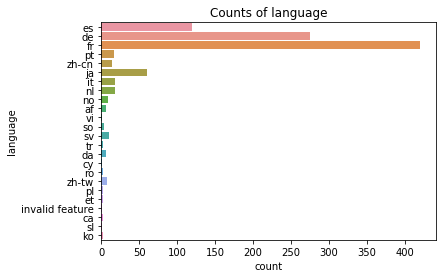

In [27]:
ax = sns.countplot(y="language", data=hotel_tem)
plt.title('Counts of language')
plt.show()

In [40]:
hotel_tem['Language'] = 'Other'
hotel_tem.loc[hotel_tem['language']=='es', 'Language'] = 'Spanish'
hotel_tem.loc[hotel_tem['language']=='de', 'Language'] = 'German'
hotel_tem.loc[hotel_tem['language']=='fr', 'Language'] = 'French'
hotel_tem.loc[hotel_tem['language']=='pt', 'Language'] = 'Portuguese'
hotel_tem.loc[hotel_tem['language']=='zh-cn', 'Language'] = 'Chinese'
hotel_tem.loc[hotel_tem['language']=='zh-tw', 'Language'] = 'Chinese'
hotel_tem.loc[hotel_tem['language']=='ja', 'Language'] = 'Japanese'
hotel_tem.loc[hotel_tem['language']=='it', 'Language'] = 'Italian'
hotel_tem.loc[hotel_tem['language']=='nl', 'Language'] = 'Dutch'

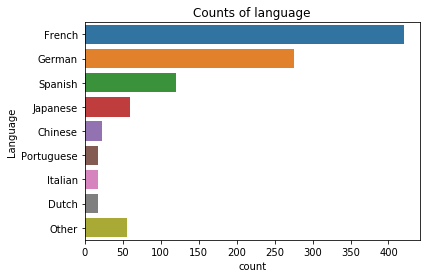

In [42]:
ax = sns.countplot(y="Language", data=hotel_tem, order = ['French', 'German', 'Spanish', 'Japanese','Chinese', 'Portuguese',
                                                          'Italian',  'Dutch', 'Other'])
plt.title('Counts of language')
plt.show()

In [56]:
hotel.drop(columns=['category', 'Language'],inplace=True)

In [57]:
hotel[hotel['language']=='invalid feature']

,stars,text,is_open,latitude,longitude,category.Restaurants,category.Food,category.Nightlife,category.Bars,category.American(Traditional),...,category.Coffee&Tea,category.Japanese,category.HomeServices,category.Desserts,category.Automotive,category.Chinese,category.SushiBars,category.Other,text_length,language
business_id,,,,,,,,,,,,,,,,,,,,,
105786,1.0,.,1.0,36.112358,-115.170221,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,invalid feature


In [59]:
import string
from googletrans import Translator
#from google.api_core.protobuf_helpers import get_messages
#from __future__ import absolute_import
from google.cloud import translate
from langdetect import detect
translator = Translator()
    
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Detect the language of the text and translate it into english
    2. Remove all punctuation
    3. Remove all stopwords
    4. Return the cleaned text as a list of words
    '''
    s = unicode(text, "utf-8")
    #if detect(s)!='en':  #translate other language to english
        #blob = blob.translate(from_lang=blob.detect_language(),to='en')
     #   s = translator.translate(s).text
    nopunc = [char for char in s if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

def clean_text(text):
    text = " ".join(text)
    return(text)

In [60]:
hotel['text_clean'] = hotel['text'].apply(lambda x: text_process(x))
hotel['text_clean'] = hotel['text_clean'].apply(lambda x: clean_text(x))

In [75]:
def get_phrases(x):
    text = x.lower()
    blob = TextBlob(text)
    return set(blob.noun_phrases)

In [99]:
hotel['phrases'] = hotel['text_clean'].apply(lambda x: get_phrases(x))
hotel['phrases'] = hotel['phrases'].apply(lambda x: list(x))

In [190]:
def count_phrase(stars):
    p_list = list(itertools.chain(*list(hotel.loc[hotel['stars']==stars, 'phrases'])))
    p_count = pd.DataFrame(Counter(p_list).most_common())
    p = pd.DataFrame(p_count[p_count.columns[1]])
    p.index = p_count[p_count.columns[0]]
    p.columns = [str(stars)]
    return p

In [191]:
p = pd.concat([count_phrase(1), count_phrase(2),count_phrase(3),count_phrase(4),count_phrase(5)],axis=1)
p = p.sort_values(by=['1'], ascending=False)
p = p.fillna(0)
phrase_sum = sum(pd.DataFrame.sum(p))

In [270]:
def draw_phrase(phrase,col):
    pl = (p[p.index==phrase].values/phrase_sum).tolist()
    pl = list(itertools.chain(*pl))
    plt.bar(x=range(1,6),height=pl,color=col)
    plt.title(phrase,fontweight="bold", fontsize=20)
    plt.xlabel('stars')
    plt.ylabel('rate')
    
    plt.show()

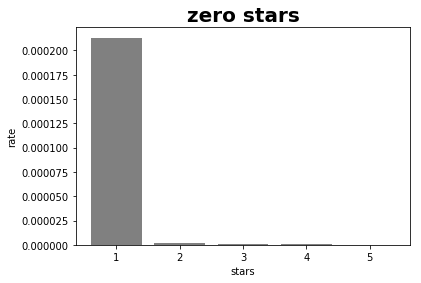

In [300]:
draw_phrase('zero stars','gray')

In [307]:
p.sort_values(by=['5'], ascending=False).head(10)

,1,2,3,4,5
las vegas,831.0,303.0,387.0,844.0,1474.0
great experience,105.0,75.0,92.0,548.0,1341.0
great service,121.0,83.0,127.0,487.0,1265.0
great time,76.0,74.0,105.0,584.0,1104.0
great place,63.0,58.0,186.0,689.0,878.0
friendly helpful,73.0,127.0,220.0,610.0,869.0
front desk,4028.0,1743.0,1149.0,1058.0,791.0
friendly staff,54.0,94.0,237.0,642.0,759.0
great hotel,56.0,65.0,109.0,600.0,657.0
great location,62.0,144.0,363.0,838.0,653.0


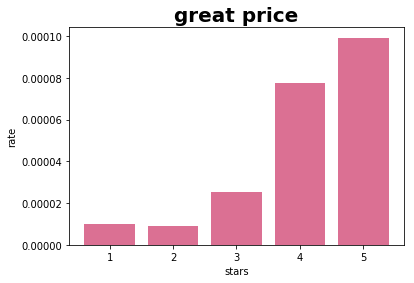

In [299]:
draw_phrase('great price','palevioletred')

In [102]:
hotel.to_csv('./data/hotel.csv',index=False)

In [194]:
p.to_csv('./data/hotel_phrase_count.csv',index=False)